# Imports

In [1]:
%load_ext autoreload
%autoreload 2

# System imports



# 3rd party imports
import tensorflow as tf
import numpy as np
from pathlib import Path

# local imports
from paperdetector.data import Dataset, DataGenerator
# end file header
__author__      = 'Adrian Lubitz'



# Dataset
[Source](https://ieeexplore.ieee.org/document/9116896)


Every sample holds an image and a corresponding CSV-File. In the CSV-File contains the following values:
- The first number is the position of X of the upper left corner
- The second number is the position of Y of the upper left corner
- The third number is the position of X of the lower left corner
- The fourth number is the position of Y of the lower left corner
- The fifth number is the position of X of the lower right corner
- The sixth number is the position of Y of the lower right corner
- The seventh number is the position of X of the upper right corner
- The eighth number is the position of Y of the upper right corner
- The text seems to be the capturing device


## Download & extract

In [2]:
# import importlib
# importlib.reload(Dataset)
d = Dataset()
# d.download_dataV3()
# d.check_integrity(clean=False, cleaned=True) # check the integrity of the cleaned dataset




downloaded, extracted and cleaned


### Visualize a random sample

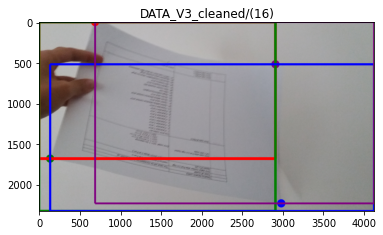

In [3]:
from paperdetector.data import Sample, resize_with_pad
# import importlib
# importlib.reload(Sample)
# if you are running this code in Jupyter notebook
%matplotlib inline 

# reads image 'opencv-logo.png' as grayscale
random_sample =  Sample(d.get_random_sample())
random_sample =  Sample('DATA_V3_cleaned/(16)')
# random_sample =  Sample("DATA_V3_cleaned/(115)")
random_sample.visualize(style=('dots','lines'), data_type='corner_refiner')

In [4]:
random_sample.visualize(seperate=True, data_type='corner_refiner')

## Create Train, Validation and Testset

In [9]:
training, validation, test = d.make_split()
# Test Generator
detection_train_dataGen = DataGenerator(training, shape=(32, 32))
detection_validation_dataGen = DataGenerator(validation, shape=(32, 32))
refiner_train_dataGen = DataGenerator(training, data_type='corner_refiner', shape=(32, 32))
refiner_validation_dataGen = DataGenerator(validation, data_type='corner_refiner', shape=(32, 32))
for sample in refiner_validation_dataGen:
    print(sample[0].shape)
    print(sample[1].shape)



(256, 32, 32, 3)
(256, 2)
(180, 32, 32, 3)
(180, 2)


## Preprocessing

What do I want to do for preprocessing - ideally nothing - model should work end-to-end

Just the resizing should be done here 
#### Options:
- `tf.image.resize_with_pad`
- I could build a dataGenerator here that loads the sample and does the resizing - ImageDataGenerator with preprocessing_function using `tf.image.resize_with_pad`
- It is also possible to use a lambda layer apparently [this](https://stackoverflow.com/questions/41758385/resizing-images-in-keras-imagedatagenerator-flow-methods) but without shape for the input layer

**The labels will be percentage values so it can be applied to any shape**

## Data Augmentation

This will be done with PAZ

In [3]:
from paperdetector.data import DataGenerator
from paz.processors import SequentialProcessor
from paz import processors as pr

augmentation_processor = SequentialProcessor([
        # We expect samples to be normalizes here
        pr.DenormalizeKeypoints2D(norm_range=(0, 1)),
        pr.RandomKeypointRotation(),
        pr.RandomKeypointTranslation(),
        pr.NormalizeKeypoints2D(norm_range=(0, 1))
    ])

all_data = DataGenerator(
            d.get_all_samples(), shape=(32, 32), augemtation_processor=augmentation_processor)

In [ ]:
# Show some samples
for a in all_data:
    print(a)

# Create Model

### Corner Detection Model

In [4]:
from paperdetector.models import build_khurramjaved96_get_corners

corner_detection_model = build_khurramjaved96_get_corners()

corner_detection_model.summary()

### Corner Refiner Model

In [6]:
from paperdetector.models import build_khurramjaved96_refine_corner

corner_refiner_model = build_khurramjaved96_refine_corner()

corner_refiner_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 10)        760       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 10)       40        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 10)        2510      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 10)       40        
 hNormalization)                                                 
                                                        

## Train Models

### Ensure GPU usage

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


### Train Corner Detection Model

In [6]:
import datetime
log_dir = "logs/fit/corner_detection" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # TODO: set to local time?
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = corner_detection_model.fit(detection_train_dataGen, validation_data=detection_validation_dataGen, epochs=10, callbacks=[tensorboard_callback])


In [ ]:
## save history for specific setting
import pickle
filename = 'mse_history'
with open(filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

: 

: 

### Train Corner Refiner

In [10]:
import datetime
log_dir = "logs/fit/corner_refiner" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # TODO: set to local time?
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = corner_refiner_model.fit(refiner_train_dataGen, validation_data=refiner_validation_dataGen, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
14/14 [==============================] - 105s 7s/step - loss: 9.4746 - mse: 9.4746 - mae: 0.2894 - mean_absolute_percentage_error: 1601891.1250 - val_loss: 0.0846 - val_mse: 0.0846 - val_mae: 0.2524 - val_mean_absolute_percentage_error: 3719133.2500
Epoch 2/10
14/14 [==============================] - 91s 7s/step - loss: 9.4369 - mse: 9.4369 - mae: 0.2764 - mean_absolute_percentage_error: 1376496.8750 - val_loss: 0.0834 - val_mse: 0.0834 - val_mae: 0.2528 - val_mean_absolute_percentage_error: 4094290.5000
Epoch 3/10
14/14 [==============================] - 91s 7s/step - loss: 9.4266 - mse: 9.4266 - mae: 0.2706 - mean_absolute_percentage_error: 1454863.6250 - val_loss: 0.0843 - val_mse: 0.0843 - val_mae: 0.2539 - val_mean_absolute_percentage_error: 4124228.0000
Epoch 4/10
14/14 [==============================] - 93s 7s/step - loss: 9.4116 - mse: 9.4116 - mae: 0.2695 - mean_absolute_percentage_error: 1273320.2500 - val_loss: 0.0824 - val_mse: 0.0824 - val_mae: 0.2506 - val_mean

# Visualize

In [ ]:
%tensorboard --logdir logs/fit